In [1]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.optimizers import *
from keras.applications import *
from keras.preprocessing.image import *

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from glob import glob
from tqdm import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import *

import multiprocessing
from multiprocessing.dummy import Pool

%matplotlib inline

Using TensorFlow backend.


In [2]:
width = 2560
height = 1920

fnames = glob('data/*/*.jpg')
np.random.shuffle(fnames)
class0 = len(glob('data/normal/*.jpg'))
class1 = len(glob('data/abnormal/*.jpg'))

n = len(fnames)

X = np.zeros((n, height, width, 3), dtype=np.uint8)
y = np.zeros((n, 1), dtype=np.uint8)

def f(index):
    return index, cv2.imread(fnames[index])

with Pool(multiprocessing.cpu_count()) as pool:
    with tqdm(pool.imap_unordered(f, range(n)), total=n) as pbar:
        for i, img in pbar:
            X[i] = img
            if 'abnormal' in fnames[i]:
                y[i] = 1
            else:
                y[i] = 0

100%|██████████| 2022/2022 [00:17<00:00, 112.85it/s]


In [3]:
# from sklearn.model_selection import train_test_split
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

n_train = int(n*0.8)
X_train = X[:n_train]
y_train = y[:n_train]
X_valid = X[n_train:]
y_valid = y[n_train:]

In [4]:
class RocAucMetricCallback(Callback):
    def __init__(self):
        super(RocAucMetricCallback, self).__init__()

    def on_epoch_end(self, epoch, logs={}):
        logs['roc_auc_val']=float('-inf')
        y_pred = model.predict(X_valid, batch_size=4)
        auc = roc_auc_score(y_valid, y_pred)
        acc = accuracy_score(y_valid[:,0], y_pred[:,0] > 0.5)
        print(f'ACC: {acc:.4f} AUC: {auc:.4f}')

In [5]:
input_tensor = Input((height, width, 3))

x = Lambda(lambda x:(x-127.0)/127.0)(input_tensor)
x = input_tensor
x = Conv2D(32, 7, activation='relu')(x)
x = MaxPool2D(2)(x)

for i in range(6):
    x = Conv2D(32*2**i, 3, activation='relu')(x)
    x = Conv2D(32*2**i, 3, activation='relu')(x)
    x = MaxPool2D(2)(x)

x = GlobalAvgPool2D()(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

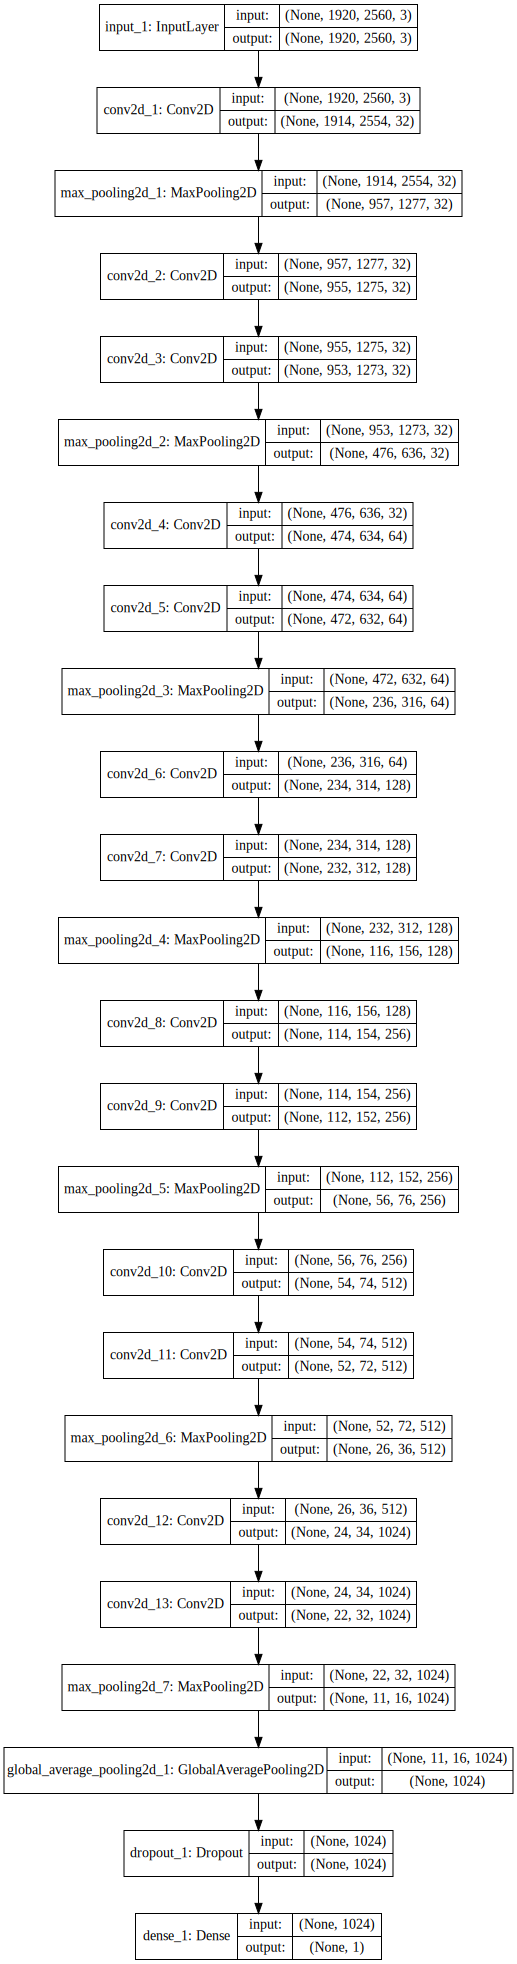

In [6]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
model.compile(optimizer=SGD(1e-3, momentum=0.9, nesterov=True), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=4, epochs=3, callbacks=[RocAucMetricCallback()])

Epoch 1/3
 668/1617 [===========>..................] - ETA: 2:25 - loss: 0.6878 - acc: 0.6332

In [ ]:
y_pred = model.predict(X_valid, verbose=1, batch_size=4)
roc_auc_score(y_valid, y_pred), accuracy_score(y_valid[:,0], y_pred[:,0] > 0.5)

In [ ]:
confusion_matrix(y_valid > 0.5, y_pred > 0.5)

In [ ]:
y_pred